In [835]:
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
from sklearn.preprocessing import PowerTransformer, label_binarize
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_curve, auc, roc_curve, silhouette_score

from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn import cluster
from sklearn.cluster import KMeans

import tensorflow as tf
import random
random.seed(17105116)
np.random.seed(17105116)
tf.random.set_seed(17105116)

# Data Preprocessing

In [786]:
# Read the CSV file and set the first row as the header
df_original = pd.read_csv('musicData.csv', header=0)

# Copy the original DataFrame
df = df_original.copy() 

# Show the first 5 rows of the DataFrame
df.head()

,instance_id,artist_name,track_name,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,obtained_date,valence,music_genre
0,32894.0,Röyksopp,Röyksopp's Night Out,27.0,0.00468,0.652,-1.0,0.941,0.79200,A#,0.115,-5.201,Minor,0.0748,100.889,4-Apr,0.759,Electronic
1,46652.0,Thievery Corporation,The Shining Path,31.0,0.01270,0.622,218293.0,0.890,0.95000,D,0.124,-7.043,Minor,0.0300,115.00200000000001,4-Apr,0.531,Electronic
2,30097.0,Dillon Francis,Hurricane,28.0,0.00306,0.620,215613.0,0.755,0.01180,G#,0.534,-4.617,Major,0.0345,127.994,4-Apr,0.333,Electronic
3,62177.0,Dubloadz,Nitro,34.0,0.02540,0.774,166875.0,0.700,0.00253,C#,0.157,-4.498,Major,0.2390,128.014,4-Apr,0.270,Electronic
4,24907.0,What So Not,Divide & Conquer,32.0,0.00465,0.638,222369.0,0.587,0.90900,F#,0.157,-6.266,Major,0.0413,145.036,4-Apr,0.323,Electronic


## Handling Music Genre

In [787]:
df['music_genre'].info()

<class 'pandas.core.series.Series'>
RangeIndex: 50005 entries, 0 to 50004
Series name: music_genre
Non-Null Count  Dtype 
--------------  ----- 
50000 non-null  object
dtypes: object(1)
memory usage: 390.8+ KB


In [788]:
df['music_genre'].isna().sum()

5

In [789]:
# Drop the null values and reset the index
df = df.dropna().reset_index(drop=True)

In [790]:
df['music_genre'].info()

<class 'pandas.core.series.Series'>
RangeIndex: 50000 entries, 0 to 49999
Series name: music_genre
Non-Null Count  Dtype 
--------------  ----- 
50000 non-null  object
dtypes: object(1)
memory usage: 390.8+ KB


In [791]:
# Creating dummy variables for the 'music_genre' column
y = pd.get_dummies(df['music_genre']).astype(int)
y.shape

(50000, 10)

In [792]:
y['Electronic'].value_counts()

Electronic
0    45000
1     5000
Name: count, dtype: int64

In [793]:
# Concatenate the key variables to the original DataFrame
df = pd.concat([df, y], axis=1)

## Handling Other Variables

In [794]:
# Loop through each column in the dataframe
for column in df.columns[:-11]:
    # Check if there are any empty values in the column
    if df[column].isnull().any():
        print(f"Column '{column}' has empty values.")
    else:
        print(f"Column '{column}' does not have empty values.")

Column 'instance_id' does not have empty values.
Column 'artist_name' does not have empty values.
Column 'track_name' does not have empty values.
Column 'popularity' does not have empty values.
Column 'acousticness' does not have empty values.
Column 'danceability' does not have empty values.
Column 'duration_ms' does not have empty values.
Column 'energy' does not have empty values.
Column 'instrumentalness' does not have empty values.
Column 'key' does not have empty values.
Column 'liveness' does not have empty values.
Column 'loudness' does not have empty values.
Column 'mode' does not have empty values.
Column 'speechiness' does not have empty values.
Column 'tempo' does not have empty values.
Column 'obtained_date' does not have empty values.
Column 'valence' does not have empty values.


In [795]:
df['popularity'].value_counts()

popularity
52.0    1316
54.0    1295
53.0    1286
50.0    1265
55.0    1250
        ... 
95.0       2
97.0       1
99.0       1
94.0       1
92.0       1
Name: count, Length: 99, dtype: int64

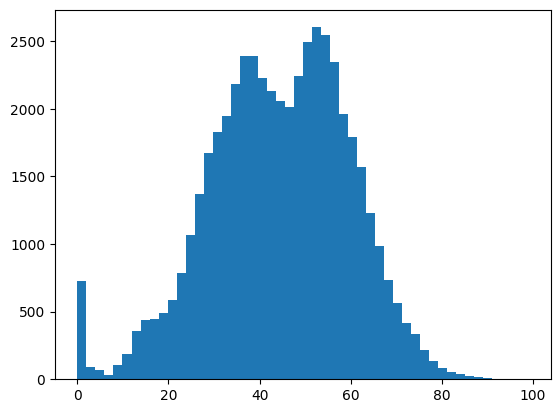

In [796]:
plt.hist(df['popularity'], bins=50)
plt.show()

In [797]:
X = pd.DataFrame()
X['popularity'] = stats.zscore(df['popularity'])
df['standardized_popularity'] = X['popularity']
df['acousticness'].value_counts()

acousticness
0.995000    278
0.994000    240
0.992000    215
0.993000    198
0.990000    158
           ... 
0.000036      1
0.000356      1
0.000074      1
0.000027      1
0.000298      1
Name: count, Length: 4193, dtype: int64

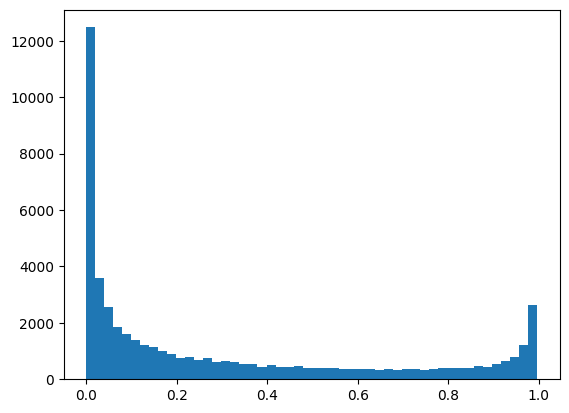

In [798]:
plt.hist(df['acousticness'], bins=50)
plt.show()

In [799]:
df['acousticness'].describe()

count    50000.000000
mean         0.306383
std          0.341340
min          0.000000
25%          0.020000
50%          0.144000
75%          0.552000
max          0.996000
Name: acousticness, dtype: float64

In [800]:
# Apply power transformation to the 'acousticness' column using
# sklearn.preprocessing.PowerTransformer(method='yeo-johnson', *, standardize=True, copy=True)
# yeo johnson because there are 0s
pt = PowerTransformer()
X['acousticness'] = pt.fit_transform(df['acousticness'].values.reshape(-1, 1))
df['standardized_acousticness'] = X['acousticness']
df['danceability'].value_counts()

danceability
0.5290    143
0.6570    139
0.6100    134
0.5540    133
0.4990    130
         ... 
0.0996      1
0.0846      1
0.0737      1
0.0817      1
0.0954      1
Name: count, Length: 1088, dtype: int64

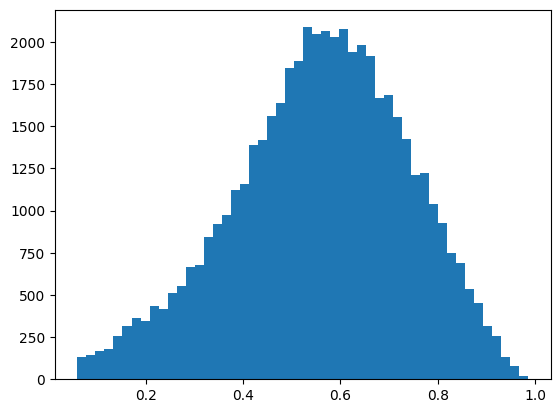

In [801]:
plt.hist(df['danceability'], bins=50)
plt.show()

In [802]:
X['danceability'] = stats.zscore(df['danceability'])
df['standardized_danceability'] = X['danceability']
df['duration_ms'].value_counts()

duration_ms
-1.0         4939
 240000.0      33
 192000.0      32
 180000.0      28
 216000.0      20
             ... 
 154574.0       1
 359213.0       1
 656213.0       1
 506320.0       1
 189483.0       1
Name: count, Length: 26028, dtype: int64

/var/folders/8p/pfvm32bd07q6ccc1n2qmv92w0000gn/T/ipykernel_67427/3190115720.py:10: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby('music_genre').apply(replace_missing_duration).reset_index(drop=True)


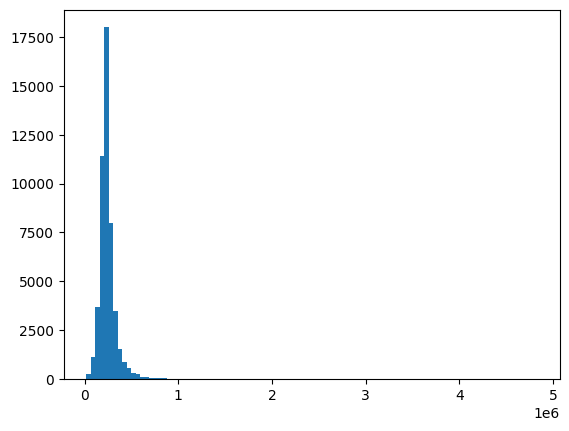

In [803]:
# Calculate the median duration for each genre
duration_median = df[df['duration_ms'] != -1].groupby('music_genre')['duration_ms'].median()

# Define a function to replace missing values with group median
def replace_missing_duration(group):
    genre = group['music_genre'].iloc[0]
    group['duration_ms'] = group['duration_ms'].replace(-1, duration_median[genre])
    return group

df = df.groupby('music_genre').apply(replace_missing_duration).reset_index(drop=True)

plt.hist(df['duration_ms'], bins=100)
plt.show()

In [804]:
X['duration_ms'] = stats.zscore(df['duration_ms'])
df['standardized_duration_ms'] = X['duration_ms']
df['energy'].value_counts()

energy
0.67500    103
0.80500    103
0.72000     99
0.85900     98
0.83000     96
          ... 
0.04500      1
0.00309      1
0.07100      1
0.06940      1
0.07420      1
Name: count, Length: 2085, dtype: int64

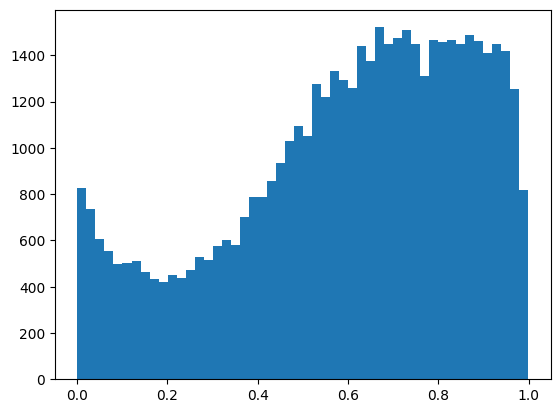

In [805]:
plt.hist(df['energy'], bins=50)
plt.show()

In [806]:
df['energy'].describe()

count    50000.000000
mean         0.599755
std          0.264559
min          0.000792
25%          0.433000
50%          0.643000
75%          0.815000
max          0.999000
Name: energy, dtype: float64

In [807]:
# Apply power transformation to the 'energy' column
# box cox because they are all positive
pt_box_cox = PowerTransformer(method='box-cox')
X['energy'] = pt_box_cox.fit_transform(df['energy'].values.reshape(-1, 1))
df['standardized_energy'] = X['energy']
df['instrumentalness'].value_counts()

instrumentalness
0.000000    15001
0.898000       70
0.902000       69
0.897000       66
0.912000       66
            ...  
0.083300        1
0.000008        1
0.088200        1
0.087400        1
0.006930        1
Name: count, Length: 5131, dtype: int64

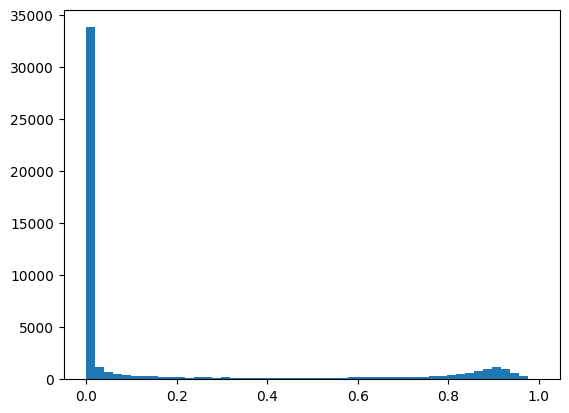

In [808]:
plt.hist(df['instrumentalness'], bins=50)
plt.show()

In [809]:
# Apply power transformation to the 'instrumentalness' column
X['instrumentalness'] = pt.fit_transform(df['instrumentalness'].values.reshape(-1, 1))
df['standardized_instrumentalness'] = X['instrumentalness']
df['key'].value_counts()

key
G     5727
C     5522
C#    5405
D     5265
A     4825
F     4341
B     3789
E     3760
A#    3356
G#    3319
F#    3101
D#    1590
Name: count, dtype: int64

In [810]:
# Create dummy variables for the key column
key_dummy_df = pd.get_dummies(df['key']).astype(int)

# Concatenate the key variables to the original DataFrame
df = pd.concat([df, key_dummy_df], axis=1)
X = pd.concat([X, key_dummy_df], axis=1)

df.columns

Index(['instance_id', 'artist_name', 'track_name', 'popularity',
       'acousticness', 'danceability', 'duration_ms', 'energy',
       'instrumentalness', 'key', 'liveness', 'loudness', 'mode',
       'speechiness', 'tempo', 'obtained_date', 'valence', 'music_genre',
       'Alternative', 'Anime', 'Blues', 'Classical', 'Country', 'Electronic',
       'Hip-Hop', 'Jazz', 'Rap', 'Rock', 'standardized_popularity',
       'standardized_acousticness', 'standardized_danceability',
       'standardized_duration_ms', 'standardized_energy',
       'standardized_instrumentalness', 'A', 'A#', 'B', 'C', 'C#', 'D', 'D#',
       'E', 'F', 'F#', 'G', 'G#'],
      dtype='object')

In [811]:
df['liveness'].value_counts()

liveness
0.11000    625
0.10800    610
0.11100    609
0.10900    552
0.10700    542
          ... 
0.02800      1
0.02260      1
0.00967      1
0.81600      1
0.04010      1
Name: count, Length: 1646, dtype: int64

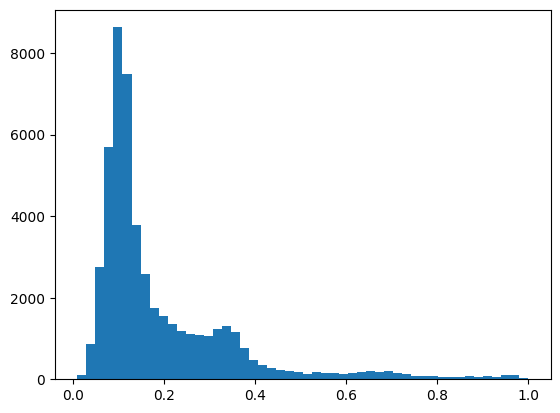

In [812]:
plt.hist(df['liveness'], bins=50)
plt.show()

In [813]:
X['liveness'] = stats.zscore(df['liveness'])
df['standardized_liveness'] = X['liveness']
df['loudness'].value_counts()

loudness
-5.443     19
-5.133     17
-7.066     17
-5.606     16
-5.982     16
           ..
-25.755     1
-19.944     1
-21.227     1
-14.315     1
-15.257     1
Name: count, Length: 17247, dtype: int64

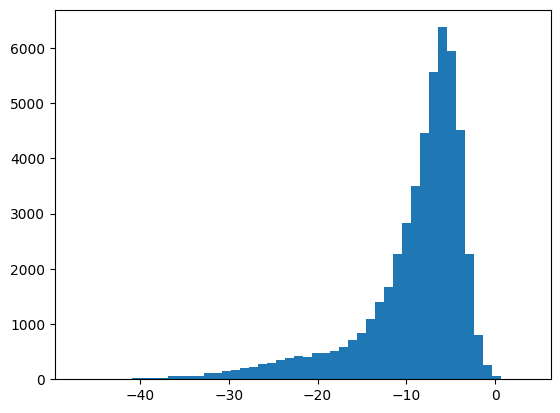

In [814]:
plt.hist(df['loudness'], bins=50)
plt.show()

In [815]:
X['loudness'] = stats.zscore(df['loudness'])
df['standardized_loudness'] = X['loudness']
df['mode'].value_counts()

mode
Major    32099
Minor    17901
Name: count, dtype: int64

In [816]:
# Create dummy variables for the mode column
mode_dummy_df = pd.get_dummies(df['mode']).astype(int)

# Concatenate the mode variables to the original DataFrame
df = pd.concat([df, mode_dummy_df], axis=1)
X = pd.concat([X, mode_dummy_df], axis=1)

df.columns

Index(['instance_id', 'artist_name', 'track_name', 'popularity',
       'acousticness', 'danceability', 'duration_ms', 'energy',
       'instrumentalness', 'key', 'liveness', 'loudness', 'mode',
       'speechiness', 'tempo', 'obtained_date', 'valence', 'music_genre',
       'Alternative', 'Anime', 'Blues', 'Classical', 'Country', 'Electronic',
       'Hip-Hop', 'Jazz', 'Rap', 'Rock', 'standardized_popularity',
       'standardized_acousticness', 'standardized_danceability',
       'standardized_duration_ms', 'standardized_energy',
       'standardized_instrumentalness', 'A', 'A#', 'B', 'C', 'C#', 'D', 'D#',
       'E', 'F', 'F#', 'G', 'G#', 'standardized_liveness',
       'standardized_loudness', 'Major', 'Minor'],
      dtype='object')

In [817]:
df['speechiness'].value_counts()

speechiness
0.0332    173
0.0337    155
0.0315    153
0.0329    152
0.0362    148
         ... 
0.7100      1
0.6370      1
0.7240      1
0.6190      1
0.5510      1
Name: count, Length: 1337, dtype: int64

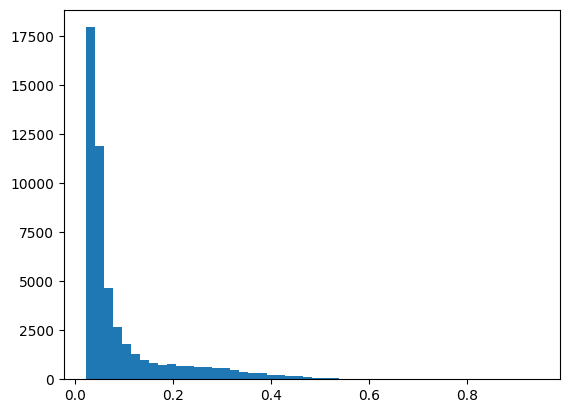

In [818]:
plt.hist(df['speechiness'], bins=50)
plt.show()

In [819]:
df['speechiness'].describe()

count    50000.000000
mean         0.093586
std          0.101373
min          0.022300
25%          0.036100
50%          0.048900
75%          0.098525
max          0.942000
Name: speechiness, dtype: float64

In [820]:
# Apply power transformation to the 'speechiness' column
X['speechiness'] = pt_box_cox.fit_transform(df['speechiness'].values.reshape(-1, 1))
df['standardized_speechiness'] = X['speechiness']
df['tempo'].value_counts()

tempo
?                     4980
120.0                   17
140.007                 17
100.00299999999999      16
120.015                 15
                      ... 
102.565                  1
61.51                    1
71.37                    1
121.945                  1
142.061                  1
Name: count, Length: 29394, dtype: int64

/var/folders/8p/pfvm32bd07q6ccc1n2qmv92w0000gn/T/ipykernel_67427/2701769883.py:13: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby('music_genre').apply(replace_missing_tempo).reset_index(drop=True)


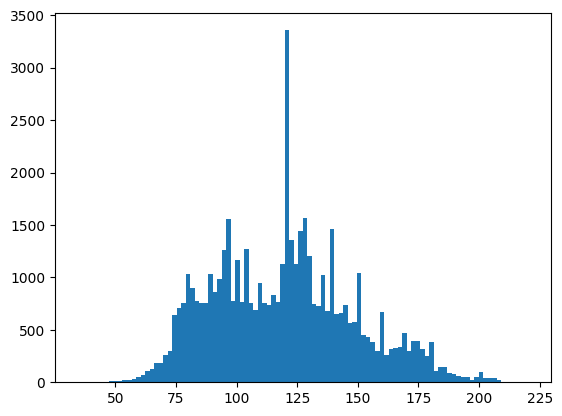

In [821]:
# Convert the 'tempo' column to numeric, replacing non-numeric values with NaN
df['tempo'] = pd.to_numeric(df['tempo'], errors='coerce')

# Calculate the median tempo for each genre
tempo_median = df.groupby('music_genre')['tempo'].median()

# Define a function to replace missing values with group median
def replace_missing_tempo(group):
    genre = group['music_genre'].iloc[0]
    group['tempo'] = group['tempo'].fillna(tempo_median[genre])
    return group

df = df.groupby('music_genre').apply(replace_missing_tempo).reset_index(drop=True)

plt.hist(df['tempo'], bins=100)
plt.show()

In [822]:
X['tempo'] = stats.zscore(df['tempo'])
df['standardized_tempo'] = X['tempo']
df['obtained_date'].value_counts()

obtained_date
4-Apr    44748
3-Apr     4067
5-Apr      784
1-Apr      400
0/4          1
Name: count, dtype: int64

/var/folders/8p/pfvm32bd07q6ccc1n2qmv92w0000gn/T/ipykernel_67427/856331651.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['obtained_date'] = df['obtained_date'].replace(date_mapping)
/var/folders/8p/pfvm32bd07q6ccc1n2qmv92w0000gn/T/ipykernel_67427/856331651.py:20: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby('music_genre').apply(replace_missing_date).reset_index(drop=True)


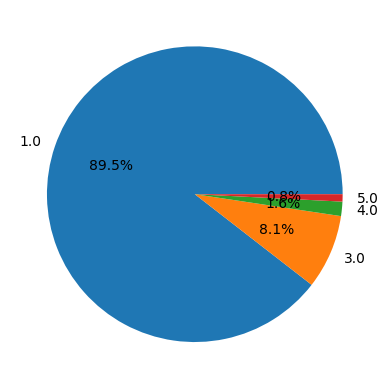

In [823]:
# Create a dictionary mapping the current values to the desired values
date_mapping = {'4-Apr': 1, '3-Apr': 3, '5-Apr': 4, '1-Apr': 5, '0/4': np.nan}

# Replace the values in the 'obtained_date' column
df['obtained_date'] = df['obtained_date'].replace(date_mapping)

# Convert the 'obtained_date' column to numeric, replacing non-numeric values with NaN
df['obtained_date'] = pd.to_numeric(df['obtained_date'], errors='coerce')

# Calculate the median obtained_date for each music genre
date_median = df.groupby('music_genre')['obtained_date'].median()

# Define a function to replace missing values with group median
def replace_missing_date(group):
    genre = group['music_genre'].iloc[0]
    group['obtained_date'] = group['obtained_date'].fillna(date_median[genre])
    return group

# Replace the NaN values in the 'obtained_date' column with the corresponding group median
df = df.groupby('music_genre').apply(replace_missing_date).reset_index(drop=True)

plt.pie(df['obtained_date'].value_counts(), labels=df['obtained_date'].value_counts().index, autopct='%1.1f%%')
plt.show()

In [824]:
# Apply power transformation to the 'obtained_date' column
X['obtained_date'] = pt_box_cox.fit_transform(df['obtained_date'].values.reshape(-1, 1))
df['standardized_obtained_date'] = X['obtained_date']
df['valence'].value_counts()

valence
0.3380    100
0.3240     95
0.3320     93
0.3510     91
0.3700     87
         ... 
0.9830      1
0.0480      1
0.0301      1
0.0278      1
0.0829      1
Name: count, Length: 1615, dtype: int64

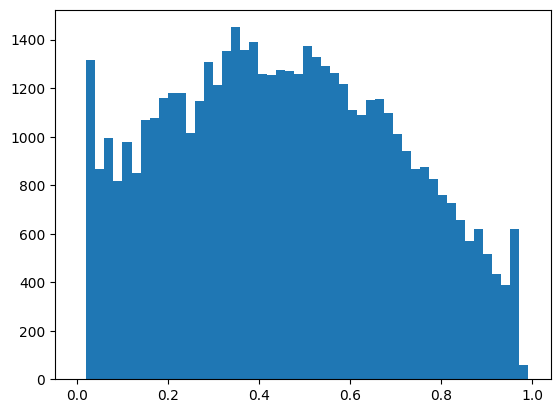

In [825]:
plt.hist(df['valence'], bins=50)
plt.show()

In [826]:
X['valence'] = stats.zscore(df['valence'])
df['standardized_valence'] = X['valence']
df.columns

Index(['instance_id', 'artist_name', 'track_name', 'popularity',
       'acousticness', 'danceability', 'duration_ms', 'energy',
       'instrumentalness', 'key', 'liveness', 'loudness', 'mode',
       'speechiness', 'tempo', 'obtained_date', 'valence', 'music_genre',
       'Alternative', 'Anime', 'Blues', 'Classical', 'Country', 'Electronic',
       'Hip-Hop', 'Jazz', 'Rap', 'Rock', 'standardized_popularity',
       'standardized_acousticness', 'standardized_danceability',
       'standardized_duration_ms', 'standardized_energy',
       'standardized_instrumentalness', 'A', 'A#', 'B', 'C', 'C#', 'D', 'D#',
       'E', 'F', 'F#', 'G', 'G#', 'standardized_liveness',
       'standardized_loudness', 'Major', 'Minor', 'standardized_speechiness',
       'standardized_tempo', 'standardized_obtained_date',
       'standardized_valence'],
      dtype='object')

In [827]:
X.columns

Index(['popularity', 'acousticness', 'danceability', 'duration_ms', 'energy',
       'instrumentalness', 'A', 'A#', 'B', 'C', 'C#', 'D', 'D#', 'E', 'F',
       'F#', 'G', 'G#', 'liveness', 'loudness', 'Major', 'Minor',
       'speechiness', 'tempo', 'obtained_date', 'valence'],
      dtype='object')

In [828]:
X

,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,A,A#,B,C,...,G,G#,liveness,loudness,Major,Minor,speechiness,tempo,obtained_date,valence
0,-1.108003,-1.115222,0.524878,1.742410,0.511416,0.345471,0,0,0,0,...,0,0,-0.704031,0.292842,1,0,-1.102943,-0.285439,-0.342554,-0.729472
1,-0.850633,-1.052978,0.356933,-0.210865,-0.631143,-0.652205,0,0,0,0,...,0,0,-0.556168,0.318641,1,0,0.990786,-1.048720,-0.342554,-0.340991
2,-1.043661,-1.128000,0.345737,0.173849,0.519422,-0.652246,0,0,0,0,...,1,0,-0.302511,0.523414,0,1,-0.712064,0.176369,-0.342554,0.662585
3,-0.657606,-0.957758,1.207853,-0.492421,0.615707,-0.652030,0,0,0,0,...,0,0,0.093442,0.642351,1,0,-0.455945,-1.017995,-0.342554,0.812312
4,-0.786291,-1.115458,0.446504,-0.167971,0.813475,-0.651607,0,0,0,0,...,0,0,0.594570,0.713421,1,0,-0.516383,0.145198,-0.342554,0.419784
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,0.950954,-0.899798,1.985998,-0.929351,1.345346,-0.652142,0,0,0,0,...,0,0,0.637877,0.877791,0,1,0.890782,0.210071,-0.342554,-0.183171
49996,1.787405,-0.168021,0.843973,2.041450,-0.806250,1.759453,1,0,0,0,...,0,0,-0.475740,-0.227853,1,0,-0.812694,0.141435,-0.342554,-1.239354
49997,0.436214,-1.105096,0.754403,-0.689189,-1.373726,-0.652246,0,0,0,0,...,0,0,-0.624222,-0.960783,1,0,-0.852506,0.736854,2.919148,0.719238
49998,1.337008,-0.571446,1.252639,0.164791,0.475423,0.698168,0,0,0,0,...,0,0,-0.525234,-0.006529,1,0,-1.211627,-0.346206,-0.342554,1.532621


## Train Test Split

In [861]:
# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, stratify=df['music_genre'], random_state=17105116)
# Print the sizes of train and test sets
print("Train set size:", X_train.shape)
print("Test set size:", X_test.shape)

Train set size: (45000, 26)
Test set size: (5000, 26)


# Dimensionality Reduction

## PCA

Find the mean $\mu$ ($d$-dimensional vector) of all samples

In [870]:
mean = np.mean(X, axis=0)
print(mean)

popularity          1.796252e-16
acousticness       -8.640200e-17
danceability       -1.250555e-16
duration_ms        -5.940137e-17
energy              4.092726e-17
instrumentalness   -6.821210e-17
A                   9.650000e-02
A#                  6.712000e-02
B                   7.578000e-02
C                   1.104400e-01
C#                  1.081000e-01
D                   1.053000e-01
D#                  3.180000e-02
E                   7.520000e-02
F                   8.682000e-02
F#                  6.202000e-02
G                   1.145400e-01
G#                  6.638000e-02
liveness           -1.045919e-16
loudness            1.716671e-16
Major               6.419800e-01
Minor               3.580200e-01
speechiness        -1.580247e-16
tempo               3.251444e-16
obtained_date       1.125500e-16
valence            -1.330136e-16
dtype: float64


Compute the covariance matrix $C = (X-\mu)^T(X-\mu)$

In [871]:
cov_matrix = (X - mean).T @ (X - mean) / (X.shape[0] - 1)
print(cov_matrix)

                  popularity  acousticness  danceability  duration_ms  \
popularity          1.000020     -0.225848      0.356427     0.114287   
acousticness       -0.225848      1.000020     -0.251772    -0.066508   
danceability        0.356427     -0.251772      1.000020     0.042751   
duration_ms         0.114287     -0.066508      0.042751     1.000020   
energy             -0.079202     -0.088328      0.098951    -0.087990   
instrumentalness    0.197730     -0.101903      0.031822     0.193234   
A                   0.002348      0.000730      0.006633     0.000223   
A#                  0.002767      0.002554     -0.003945     0.001367   
B                  -0.001414     -0.001159      0.001465    -0.002551   
C                   0.000080      0.002147      0.000671     0.002423   
C#                 -0.009920      0.003874     -0.008580    -0.007007   
D                   0.000559     -0.000797      0.003477     0.003364   
D#                  0.001912      0.000173     -0.0

Compute the $k$ eigenvectors of $C$ (ordered by decreasing eigenvalues)

In [873]:
eigvals, eigvecs = np.linalg.eig(cov_matrix)
print(eigvals.shape, eigvecs.shape, eigvals)

(26,) (26, 26) [ 2.82902510e+00  1.70038784e+00  1.10278320e+00  9.32088390e-01
  9.87400363e-01  8.55298042e-01  8.02557517e-01  7.50906250e-01
  7.15645816e-01  5.99156070e-01  6.13610103e-01  4.40285490e-01
  1.43659540e-01  3.33415539e-02  1.12872791e-01  1.07900225e-01
  1.05179258e-01  9.74008811e-02  8.83801693e-02  6.26670509e-02
  6.52812478e-02  6.95771374e-02  7.93063205e-02  7.51335596e-02
  2.81796709e-17 -1.69063428e-18]


In [874]:
# keep the first 3 principal components of the data
pca = PCA(n_components=3, whiten=True, random_state=17105116)
# fit and transform PCA model to wine data
X_pca = pca.fit_transform(X)

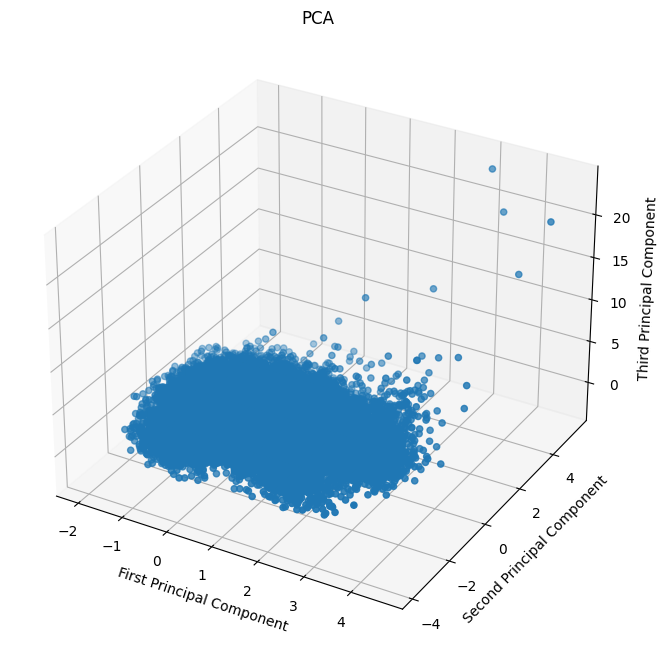

In [926]:
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X_pca[:, 0], X_pca[:, 1], X_pca[:, 2])
ax.set_xlabel('First Principal Component')
ax.set_ylabel('Second Principal Component')
ax.set_zlabel('Third Principal Component')
ax.set_title('PCA')
plt.show()

## T-SNE

In [927]:
X_tsne = TSNE(n_components=3, perplexity=20, n_jobs=-1, random_state=17105116).fit_transform(X)

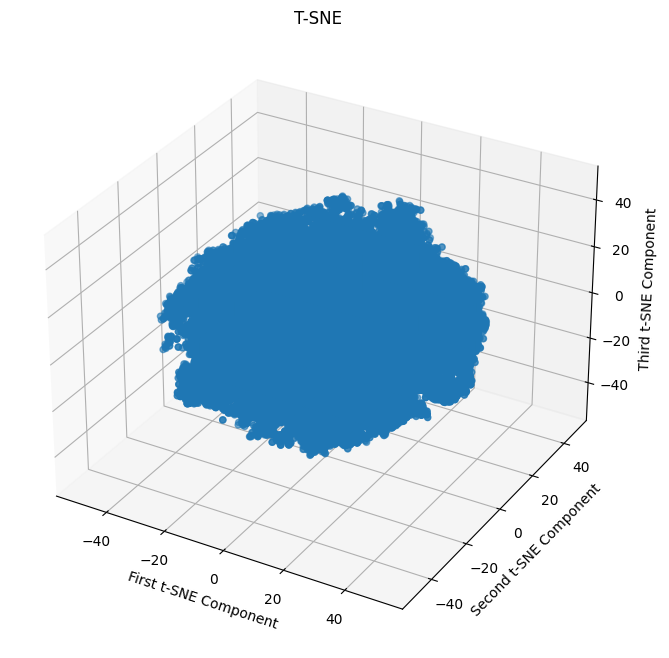

In [928]:
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X_tsne[:, 0], X_tsne[:, 1], X_tsne[:, 2])
ax.set_xlabel('First t-SNE Component')
ax.set_ylabel('Second t-SNE Component')
ax.set_zlabel('Third t-SNE Component')
ax.set_title('T-SNE')
plt.show()

# Clustering

## Building on PCA

In [912]:
silhouettes = np.zeros(15)

for k in range(2,12):
    kmeans = cluster.KMeans(k, n_init='auto')
    labels = kmeans.fit_predict(X_pca)
    silhouettes[k-1] = silhouette_score(X_pca, labels)

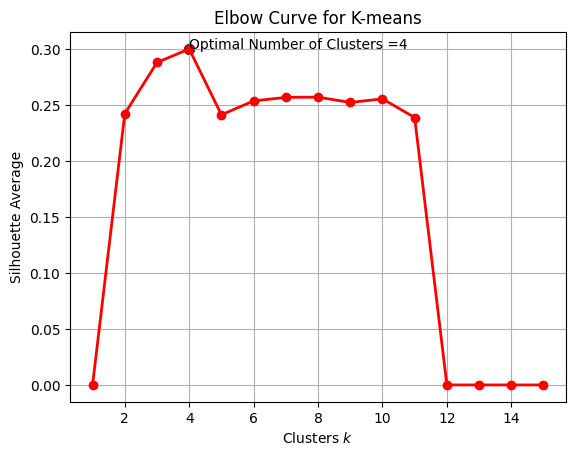

In [913]:
plt.plot(np.arange(1, 16, 1), silhouettes, 'r-o', lw = 2)
max_index = np.argmax(silhouettes)
optimal_num_clusters = max_index + 1
max_score = silhouettes[max_index]
plt.scatter(optimal_num_clusters, max_score, color='black', marker='o', s=50)
plt.text(optimal_num_clusters, max_score, f'Optimal Number of Clusters ={optimal_num_clusters}')
plt.xlabel(r'Clusters $k$')
plt.ylabel(r'Silhouette Average')
plt.title(r'Elbow Curve for K-means')
plt.grid()
plt.show()

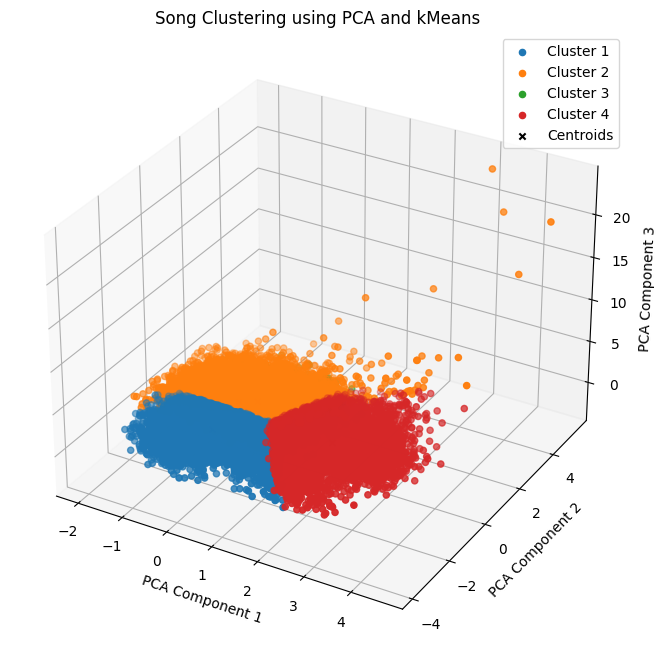

In [920]:
# Perform KMeans Clustering with Optimal Number of Clusters
kmeans = KMeans(n_clusters=optimal_num_clusters)
cluster_labels = kmeans.fit_predict(X_pca)

# Plot the Results
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')
for i in range(optimal_num_clusters):
    ax.scatter(X_pca[cluster_labels == i, 0], X_pca[cluster_labels == i, 1], X_pca[cluster_labels == i, 2], label=f'Cluster {i+1}')
ax.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], marker='x', color='black', label='Centroids')
ax.set_title('Song Clustering using PCA and kMeans')
ax.set_xlabel('PCA Component 1')
ax.set_ylabel('PCA Component 2')
ax.set_zlabel('PCA Component 3')
ax.legend()
plt.show()

## Building on t-SNE

In [921]:
silhouettes = np.zeros(15)

for k in range(2,12):
    kmeans = cluster.KMeans(k, n_init='auto')
    labels = kmeans.fit_predict(X_tsne)
    silhouettes[k-1] = silhouette_score(X_tsne, labels)

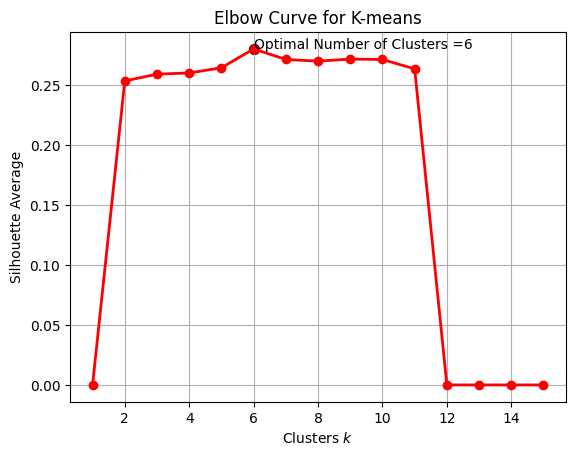

In [922]:
plt.plot(np.arange(1, 16, 1), silhouettes, 'r-o', lw = 2)
max_index = np.argmax(silhouettes)
optimal_num_clusters = max_index + 1
max_score = silhouettes[max_index]
plt.scatter(optimal_num_clusters, max_score, color='black', marker='o', s=50)
plt.text(optimal_num_clusters, max_score, f'Optimal Number of Clusters ={optimal_num_clusters}')
plt.xlabel(r'Clusters $k$')
plt.ylabel(r'Silhouette Average')
plt.title(r'Elbow Curve for K-means')
plt.grid()
plt.show()

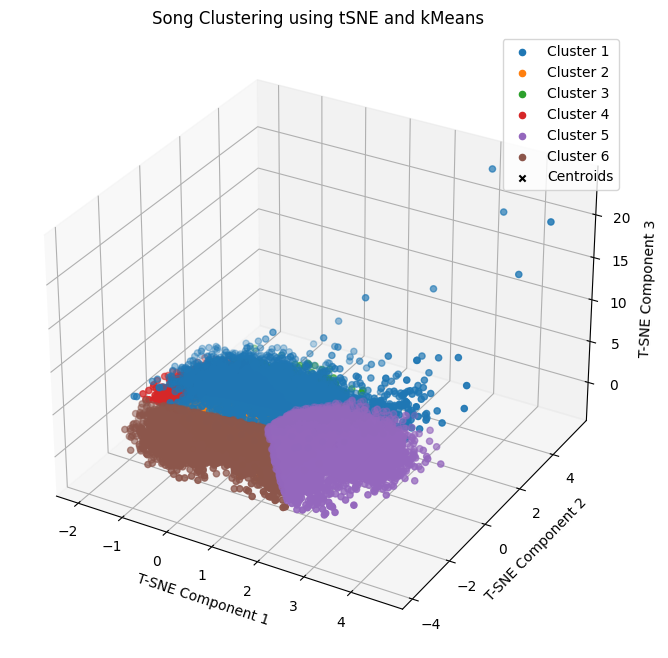

In [923]:
# Perform KMeans Clustering with Optimal Number of Clusters
kmeans = KMeans(n_clusters=optimal_num_clusters)
cluster_labels = kmeans.fit_predict(X_pca)

# Plot the Results
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')
for i in range(optimal_num_clusters):
    ax.scatter(X_pca[cluster_labels == i, 0], X_pca[cluster_labels == i, 1], X_pca[cluster_labels == i, 2], label=f'Cluster {i+1}')
ax.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], marker='x', color='black', label='Centroids')
ax.set_title('Song Clustering using tSNE and kMeans')
ax.set_xlabel('T-SNE Component 1')
ax.set_ylabel('T-SNE Component 2')
ax.set_zlabel('T-SNE Component 3')
ax.legend()
plt.show()

# SVM

## SVM without Dimensionality Reduction

In [902]:
# Initializing and training the svm
svm = OneVsRestClassifier(LinearSVC(dual = False, random_state=17105116))
svm.fit(X_train, y_train)

y_prob_svm = svm.decision_function(X_test)

In [891]:
# Binarize the output
y_test_bin = label_binarize(y_test, classes=[0,1,2,3,4,5,6,7,8,9])
n_classes = y_test_bin.shape[1]

# Compute ROC curve and ROC area for each class
fpr_svm = dict()
tpr_svm = dict()
auroc_svm = dict()
for i in range(n_classes):
    fpr_svm[i], tpr_svm[i], _ = roc_curve(y_test_bin[:, i], y_prob_svm[:, i])
    auroc_svm[i] = auc(fpr_svm[i], tpr_svm[i])

# Compute micro-average ROC curve and ROC area
fpr_svm["micro"], tpr_svm["micro"], _ = roc_curve(y_test_bin.ravel(), y_prob_svm.ravel())
auroc_svm["micro"] = auc(fpr_svm["micro"], tpr_svm["micro"])

print('Linear SVM AUROC (without dimensionality reduction): %.2f' % auroc_svm["micro"])

# Compute Precision-Recall and plot curve
precision_svm = dict()
recall_svm = dict()
auprc_svm = dict()
for i in range(n_classes):
    precision_svm[i], recall_svm[i], _ = precision_recall_curve(y_test_bin[:, i], y_prob_svm[:, i])
    auprc_svm[i] = auc(recall_svm[i], precision_svm[i])

# Compute micro-average Precision-Recall curve and AUPRC
precision_svm["micro"], recall_svm["micro"], _ = precision_recall_curve(y_test_bin.ravel(), y_prob_svm.ravel())
auprc_svm["micro"] = auc(recall_svm["micro"], precision_svm["micro"])

print('Linear SVM AUPRC (without dimensionality reduction): %.2f' % auprc_svm["micro"])

Linear SVM AUROC (without dimensionality reduction): 0.91
Linear SVM AUPRC (without dimensionality reduction): 0.60


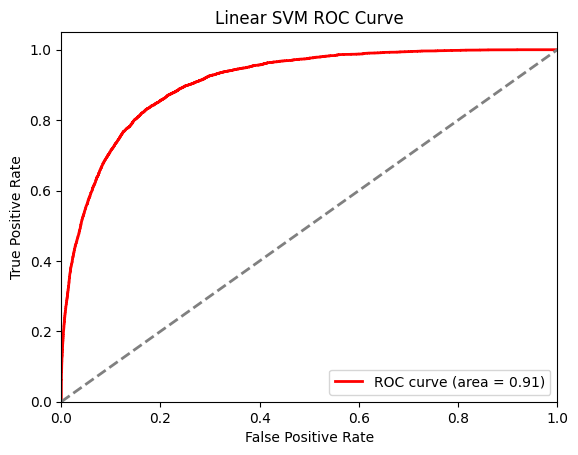

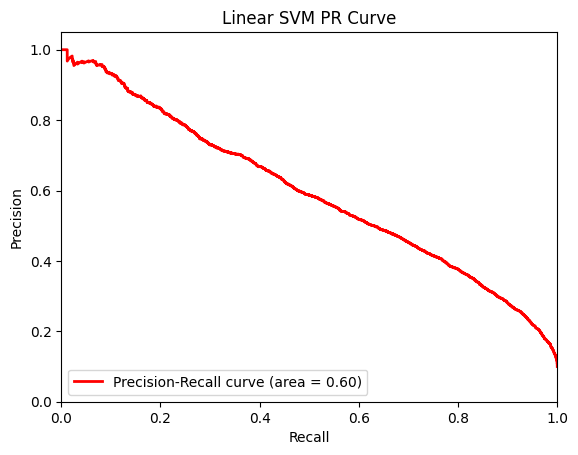

In [892]:
# Plot ROC curve
plt.figure()
lw = 2
plt.plot(fpr_svm["micro"], tpr_svm["micro"], color='r',
         lw=lw, label='AUROC = %0.2f' % auroc_svm["micro"])
plt.plot([0, 1], [0, 1], color='gray', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Linear SVM ROC Curve')
plt.legend(loc="lower right")
plt.show()

# Plot Precision-Recall curve
plt.figure()
plt.plot(recall_svm["micro"], precision_svm["micro"], color='r',
         lw=lw, label='AUPRC = %0.2f' % auprc_svm["micro"])
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Linear SVM PR Curve')
plt.legend(loc="lower left")
plt.show()

## SVM with PCA

In [893]:
# Splitting the data into training and testing sets
X_pca_train, X_pca_test, y_pca_train, y_pca_test = train_test_split(X_pca, y, test_size=0.2, random_state=17105116)

# Initializing and training the svm
svm = OneVsRestClassifier(LinearSVC(dual = False, random_state=17105116))
svm.fit(X_pca_train, y_pca_train)

y_pca_prob_svm = svm.decision_function(X_pca_test)

In [894]:
# Binarize the output
y_pca_test_bin = label_binarize(y_pca_test, classes=[0,1,2,3,4,5,6,7,8,9])
n_classes_pca = y_pca_test_bin.shape[1]

# Compute ROC curve and ROC area for each class
fpr_pca_svm = dict()
tpr_pca_svm = dict()
auroc_pca_svm = dict()
for i in range(n_classes_pca):
    fpr_pca_svm[i], tpr_pca_svm[i], _ = roc_curve(y_pca_test_bin[:, i], y_pca_prob_svm[:, i])
    auroc_pca_svm[i] = auc(fpr_pca_svm[i], tpr_pca_svm[i])

# Compute micro-average ROC curve and ROC area
fpr_pca_svm["micro"], tpr_pca_svm["micro"], _ = roc_curve(y_pca_test_bin.ravel(), y_pca_prob_svm.ravel())
auroc_pca_svm["micro"] = auc(fpr_pca_svm["micro"], tpr_pca_svm["micro"])

print('Linear SVM AUROC (with PCA): %.2f' % auroc_pca_svm["micro"])

# Compute Precision-Recall and plot curve
precision_pca_svm = dict()
recall_pca_svm = dict()
auprc_pca_svm = dict()
for i in range(n_classes_pca):
    precision_pca_svm[i], recall_pca_svm[i], _ = precision_recall_curve(y_pca_test_bin[:, i], y_pca_prob_svm[:, i])
    auprc_pca_svm[i] = auc(recall_pca_svm[i], precision_pca_svm[i])

# Compute micro-average Precision-Recall curve and AUPRC
precision_pca_svm["micro"], recall_pca_svm["micro"], _ = precision_recall_curve(y_pca_test_bin.ravel(), y_pca_prob_svm.ravel())
auprc_pca_svm["micro"] = auc(recall_pca_svm["micro"], precision_pca_svm["micro"])

print('Linear SVM AUPRC (with PCA): %.2f' % auprc_pca_svm["micro"])

Linear SVM AUROC (with PCA): 0.82
Linear SVM AUPRC (with PCA): 0.41


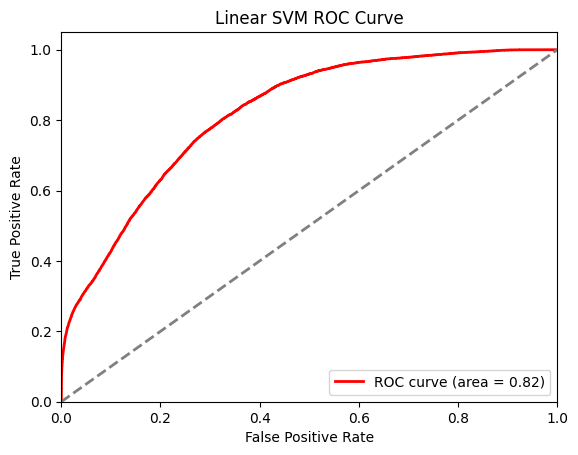

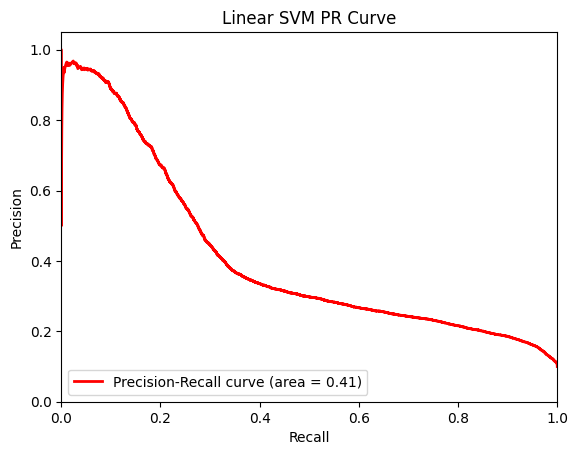

In [896]:
# Plot ROC curve
plt.figure()
lw = 2
plt.plot(fpr_pca_svm["micro"], tpr_pca_svm["micro"], color='r',
         lw=lw, label='AUROC = %0.2f' % auroc_pca_svm["micro"])
plt.plot([0, 1], [0, 1], color='gray', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Linear SVM ROC Curve')
plt.legend(loc="lower right")
plt.show()

# Plot Precision-Recall curve
plt.figure()
plt.plot(recall_pca_svm["micro"], precision_pca_svm["micro"], color='r',
         lw=lw, label='AUPRC = %0.2f' % auprc_pca_svm["micro"])
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Linear SVM PR Curve')
plt.legend(loc="lower left")
plt.show()

## SVM with t-SNE

In [897]:
# Splitting the data into training and testing sets
X_tsne_train, X_tsne_test, y_tsne_train, y_tsne_test = train_test_split(X_tsne, y, test_size=0.2, random_state=17105116)

# Initializing and training the svm
svm = OneVsRestClassifier(LinearSVC(dual = False, random_state=17105116))
svm.fit(X_tsne_train, y_tsne_train)

y_tsne_prob_svm = svm.decision_function(X_tsne_test)

In [899]:
# Binarize the output
y_tsne_test_bin = label_binarize(y_tsne_test, classes=[0,1,2,3,4,5,6,7,8,9])
n_classes_tsne = y_tsne_test_bin.shape[1]

# Compute ROC curve and ROC area for each class
fpr_tsne_svm = dict()
tpr_tsne_svm = dict()
auroc_tsne_svm = dict()
for i in range(n_classes_tsne):
    fpr_tsne_svm[i], tpr_tsne_svm[i], _ = roc_curve(y_tsne_test_bin[:, i], y_tsne_prob_svm[:, i])
    auroc_tsne_svm[i] = auc(fpr_tsne_svm[i], tpr_tsne_svm[i])

# Compute micro-average ROC curve and ROC area
fpr_tsne_svm["micro"], tpr_tsne_svm["micro"], _ = roc_curve(y_tsne_test_bin.ravel(), y_tsne_prob_svm.ravel())
auroc_tsne_svm["micro"] = auc(fpr_tsne_svm["micro"], tpr_tsne_svm["micro"])

print('Linear SVM AUROC (with tSNE): %.2f' % auroc_tsne_svm["micro"])

# Compute Precision-Recall and plot curve
precision_tsne_svm = dict()
recall_tsne_svm = dict()
auprc_tsne_svm = dict()
for i in range(n_classes_tsne):
    precision_tsne_svm[i], recall_tsne_svm[i], _ = precision_recall_curve(y_tsne_test_bin[:, i], y_tsne_prob_svm[:, i])
    auprc_tsne_svm[i] = auc(recall_tsne_svm[i], precision_tsne_svm[i])

# Compute micro-average Precision-Recall curve and AUPRC
precision_tsne_svm["micro"], recall_tsne_svm["micro"], _ = precision_recall_curve(y_tsne_test_bin.ravel(), y_tsne_prob_svm.ravel())
auprc_tsne_svm["micro"] = auc(recall_tsne_svm["micro"], precision_tsne_svm["micro"])

print('Linear SVM AUPRC (with tSNE): %.2f' % auprc_tsne_svm["micro"])

Linear SVM AUROC (with tSNE): 0.76
Linear SVM AUPRC (with tSNE): 0.33


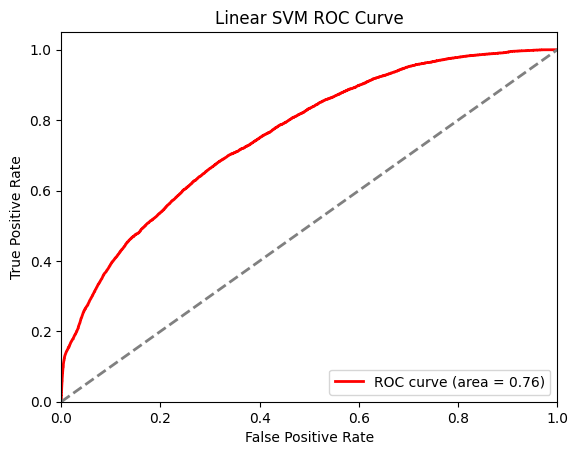

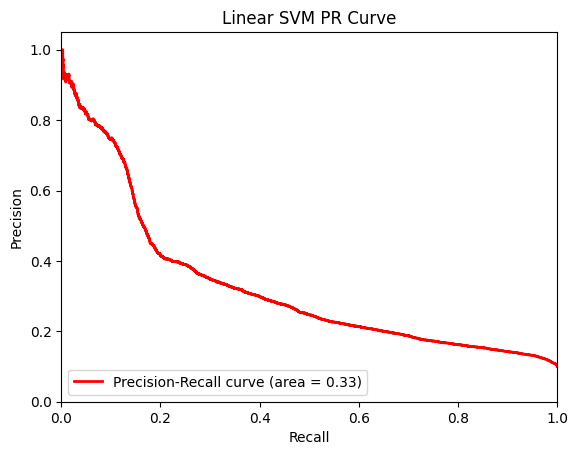

In [900]:
# Plot ROC curve
plt.figure()
lw = 2
plt.plot(fpr_tsne_svm["micro"], tpr_tsne_svm["micro"], color='r',
         lw=lw, label='AUROC = %0.2f' % auroc_tsne_svm["micro"])
plt.plot([0, 1], [0, 1], color='gray', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Linear SVM ROC Curve')
plt.legend(loc="lower right")
plt.show()

# Plot Precision-Recall curve
plt.figure()
plt.plot(recall_tsne_svm["micro"], precision_tsne_svm["micro"], color='r',
         lw=lw, label='AUPRC = %0.2f' % auprc_tsne_svm["micro"])
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Linear SVM PR Curve')
plt.legend(loc="lower left")
plt.show()